TMI Inversion: Block in Halfspace (Smooth)
====================================

## Geoscientific Problem

For this code comparison, we inverted total magnetic intensity (TMI) data collected over a block within a homogeneous halfspace. For each coding package, we invert for the smoothest model using an unconstrained least-squares inversion approach.

The true model consists of a susceptible block (0.025 SI) within a minimally susceptible halfspace (0.0001 SI).
The dimensions of the block in the x, y and z directions were are all 200 m. The block was buried at a depth of 200 m. The Earth's inducing field had an inclination of 65 degrees, a declination of 25 degrees and an intensity of 50,000 nT.

The data being inverted were generated using the [UBC MAG3D v6.0.1 code](https://mag3d.readthedocs.io/en/v6/). Synthetic TMI data were simulated within a 1000 m by 1000 m region at an elevation of 30 m; the center of which lied directly over the center of the block. The station spacing was 50 m in both the X and Y directions. Observed data were sythnetically created by adding Gaussian noise with a standard deviation of 1 nT to the simulated data. A floor uncertainty of 1 nT was assigned to the observed data.

## Codes/Formulations Being Compared

**SimPEG 3D Integral Formulation:** This approach to solving the forward problem uses the *SimPEG.potential_fields.magnetics.simulation.Simulation3DIntegral* simulation class.

**UBC MAG3D v6.0:** [MAG3D v6.0](https://mag3d.readthedocs.io/en/v6/) is a voxel cell magnetic forward modeling and inversion package developed by the UBC Geophysical Inversion Facility. This software is proprietary and can ONLY be acquired through appropriate [academic](https://gif.eos.ubc.ca/software/licenses_academic) or [commerical](https://gif.eos.ubc.ca/software/licenses_commercial) licenses. The numerical approach of the forward simulation is described in the [online manual's theory section](https://mag3d.readthedocs.io/en/v6/content/theory.html). If you have a valid license, there are instructions for reproducing the results (add link). 

## Loading Assets Into the SimPEG Framework

We start by importing any necessary packages for running the notebook.

In [1]:
from SimPEG.potential_fields import magnetics
from SimPEG.utils import plot2Ddata
from SimPEG.utils.io_utils import read_mag3d_ubc
from SimPEG import maps, data_misfit, regularization, optimization, inverse_problem, inversion, directives
from discretize import TensorMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

Next we download the mesh, true model, recovered model, predicted data and observed data for each coding package/formulation.

In [2]:
# For each package, download .tar files

For each coding package/formulation, the assets are loaded into the SimPEG framework

In [3]:
rootdir = './../../../assets/magnetics/block_halfspace_tmi_inv_smooth_simpeg/'
mesh_simpeg = TensorMesh.read_UBC(rootdir+'mesh.txt')
true_model_simpeg = TensorMesh.read_model_UBC(mesh_simpeg, rootdir+'true_model.sus')
recovered_model_simpeg = TensorMesh.read_model_UBC(mesh_simpeg, rootdir+'recovered_model.sus')
dobs_simpeg = read_mag3d_ubc(rootdir+'dobs.mag')
dpred_simpeg = read_mag3d_ubc(rootdir+'dpred.mag')

rootdir = './../../../assets/magnetics/block_halfspace_tmi_inv_smooth_mag3d/'
mesh_ubc = TensorMesh.read_UBC(rootdir+'mesh.txt')
true_model_ubc = TensorMesh.read_model_UBC(mesh_simpeg, rootdir+'true_model.sus')
recovered_model_ubc = TensorMesh.read_model_UBC(mesh_simpeg, rootdir+'maginv3d_002.sus')
dobs_ubc = read_mag3d_ubc(rootdir+'dobs.mag')
dpred_ubc = read_mag3d_ubc(rootdir+'maginv3d_002.pre')

## True Model and Survey Geometry

Text(0, 0.5, 'y (m)')

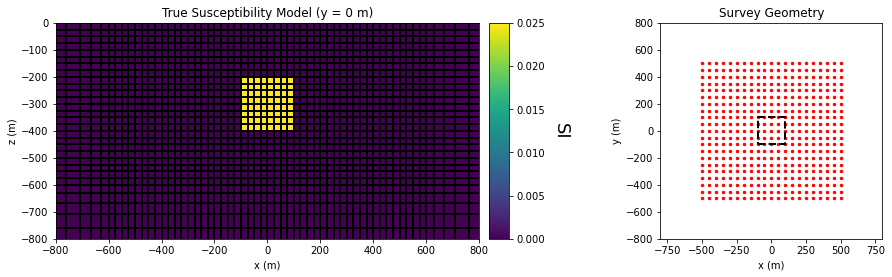

In [4]:
fig = plt.figure(figsize=(14, 4))

ax11 = fig.add_axes([0.1, 0.15, 0.42, 0.75])
ind = int(mesh_simpeg.shape_cells[1]/2)
mesh_simpeg.plot_slice(
    true_model_simpeg, normal='Y', ind=ind, grid=True, ax=ax11, pcolor_opts={"cmap": "viridis"}
)

ax11.set_xlim([-800, 800])
ax11.set_ylim([-800, 0])
ax11.set_title("True Susceptibility Model (y = 0 m)")
ax11.set_xlabel("x (m)")
ax11.set_ylabel("z (m)")

ax12 = fig.add_axes([0.53, 0.15, 0.02, 0.75])
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(true_model_simpeg))
cbar = mpl.colorbar.ColorbarBase(
    ax12, norm=norm, cmap=mpl.cm.viridis, orientation="vertical"
)
cbar.set_label("SI", rotation=270, labelpad=25, size=18)

xyz = dobs_simpeg.survey.receiver_locations
ax21 = fig.add_axes([0.7, 0.15, 0.22, 0.75])
ax21.scatter(xyz[:, 0], xyz[:, 1], 6, 'r')
ax21.plot(100*np.r_[-1, 1, 1, -1, -1], 100*np.r_[-1, -1, 1, 1, -1], 'k--', lw=2.)
ax21.set_xlim([-800, 800])
ax21.set_ylim([-800, 800])
ax21.set_title("Survey Geometry")
ax21.set_xlabel("x (m)")
ax21.set_ylabel("y (m)")

## Comparing Recovered Models

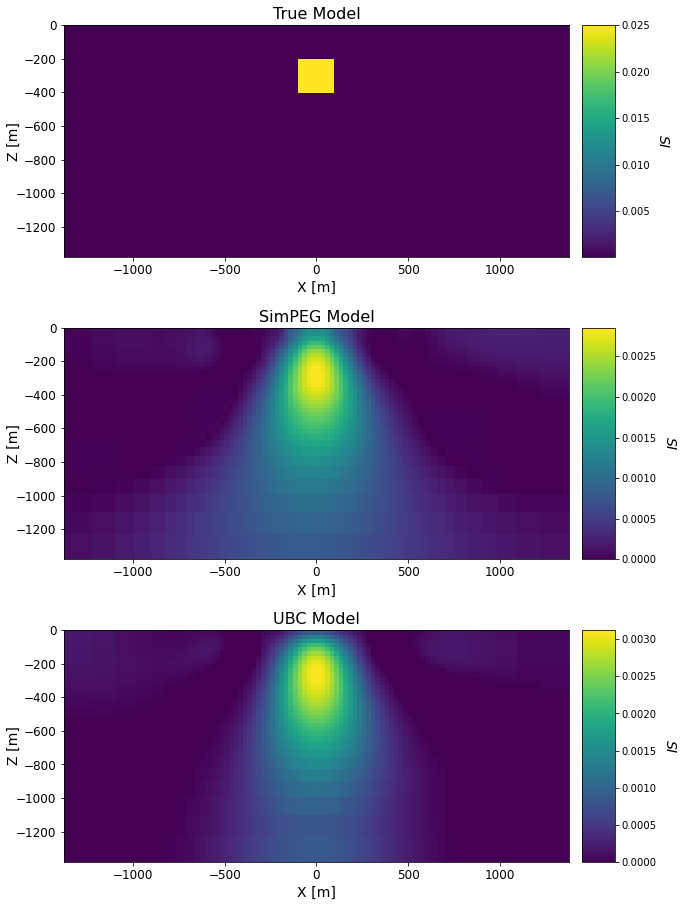

In [5]:
fig = plt.figure(figsize=(9, 14))
font_size = 14

models_list = [true_model_simpeg, recovered_model_simpeg, recovered_model_ubc]
titles_list = ['True Model', 'SimPEG Model', 'UBC Model']
ax1 = 3*[None]
cplot = 3*[None]
ax2 = 3*[None]
cbar = 3*[None]

for qq in range(0, 3):
    ax1[qq] = fig.add_axes([0.1, 0.65 - 0.3*qq, 0.78, 0.23])
    
    cplot[qq] = mesh_simpeg.plot_slice(
        models_list[qq], normal='Y', ind=int(mesh_simpeg.shape_cells[1]/2), grid=False, ax=ax1[qq]
    )
    cplot[qq][0].set_clim((np.min(models_list[qq]), np.max(models_list[qq])))
    ax1[qq].set_xlabel("X [m]", fontsize=font_size)
    ax1[qq].set_ylabel("Z [m]", fontsize=font_size, labelpad=-5)
    ax1[qq].tick_params(labelsize=font_size - 2)
    ax1[qq].set_title(titles_list[qq], fontsize=font_size + 2)
    
    ax2[qq] = fig.add_axes([0.9, 0.65 - 0.3*qq, 0.05, 0.23])
    norm = mpl.colors.Normalize(vmin=np.min(models_list[qq]), vmax=np.max(models_list[qq]))
    cbar[qq] = mpl.colorbar.ColorbarBase(
        ax2[qq], norm=norm, orientation="vertical"
    )
    cbar[qq].set_label(
        "$SI$",
        rotation=270,
        labelpad=20,
        size=font_size,
)

plt.show()

## Comparing Data Misfits

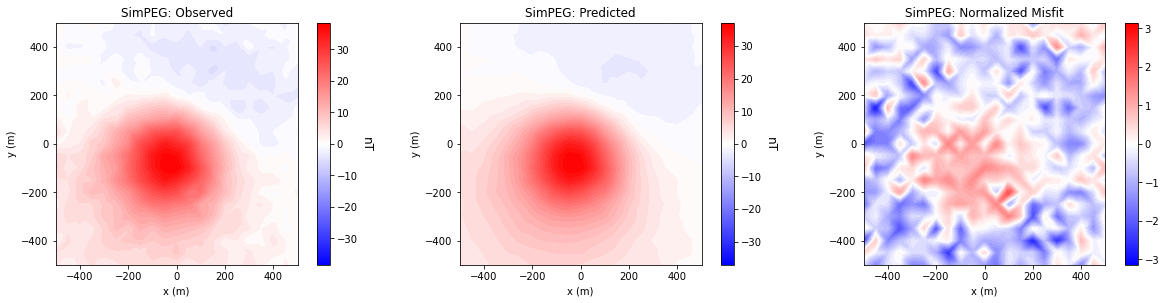

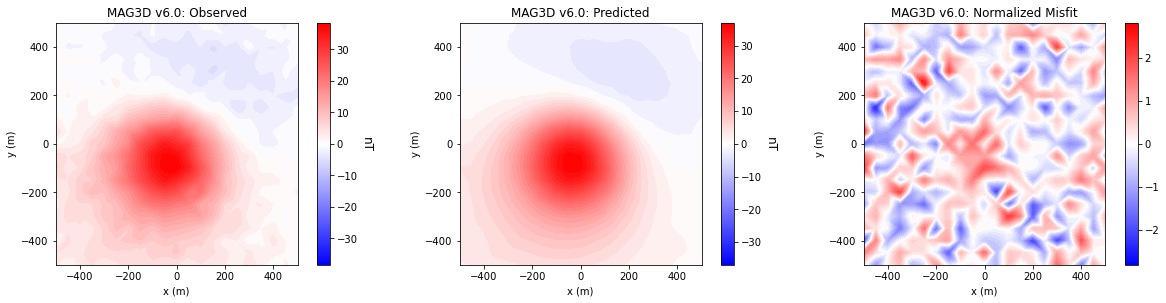

In [6]:
data_array = [
    [
        dobs_simpeg.dobs,
        dpred_simpeg.dobs,
        (dobs_simpeg.dobs - dpred_simpeg.dobs) / dobs_simpeg.standard_deviation
    ], [
        dobs_ubc.dobs,
        dpred_ubc.dobs,
        (dobs_ubc.dobs - dpred_ubc.dobs) / dobs_ubc.standard_deviation
    ]
]
code_name = ['SimPEG', 'MAG3D v6.0']

for ii in range(0, len(data_array)):

    fig = plt.figure(figsize=(17, 4))
    
    plot_title = ["Observed", "Predicted", "Normalized Misfit"]
    plot_units = ["nT", "nT", ""]

    ax1 = 3 * [None]
    ax2 = 3 * [None]
    norm = 3 * [None]
    cbar = 3 * [None]
    cplot = 3 * [None]
    
    v_lim = [
        np.max(np.abs(data_array[ii][0])),
        np.max(np.abs(data_array[ii][1])),
        np.max(np.abs(data_array[ii][2]))
    ]

    for jj in range(0, 3):

        ax1[jj] = fig.add_axes([0.33 * jj + 0.03, 0.11, 0.25, 0.84])
        cplot[jj] = plot2Ddata(
            xyz,
            data_array[ii][jj],
            ax=ax1[jj],
            ncontour=50,
            clim=(-v_lim[jj], v_lim[jj]),
            contourOpts={"cmap": "bwr"}
        )
        ax1[jj].set_title(code_name[ii] + ': ' + plot_title[jj])
        ax1[jj].set_xlabel("x (m)")
        ax1[jj].set_ylabel("y (m)")

        ax2[jj] = fig.add_axes([0.33 * jj + 0.27, 0.11, 0.01, 0.84])
        norm[jj] = mpl.colors.Normalize(vmin=-v_lim[jj], vmax=v_lim[jj])
        cbar[jj] = mpl.colorbar.ColorbarBase(
            ax2[jj], norm=norm[jj], orientation="vertical", cmap=mpl.cm.bwr
        )
        cbar[jj].set_label(plot_units[jj], rotation=270, labelpad=15, size=12)

    plt.show()